Full HHL Quantum Circuit:
HHL Final Measurement Counts:
{'001000000001': 4970, '011000000101': 22, '000000000001': 713, '101100100101': 1, '100000000101': 32, '011000000011': 18, '001000000111': 299, '010000000001': 2878, '001000011110': 1, '011000000010': 11, '001000000110': 252, '011000000100': 8, '001000000000': 269, '100000000011': 74, '011000001001': 9, '011000010111': 1, '001000010011': 20, '101000000010': 18, '000000000111': 5, '100000010001': 2, '011000001111': 5, '001000001011': 68, '100000000100': 25, '001001000011': 1, '101000000100': 11, '010001100001': 1, '011000001110': 2, '001000010010': 15, '001000001010': 50, '000000001011': 2, '101000000011': 16, '001001000010': 1, '101000000101': 21, '010000000110': 9, '101000010001': 2, '001000100011': 7, '100000000010': 42, '010000000111': 9, '001000001100': 7, '010000000000': 20, '011000001000': 7, '001000001101': 8, '101000001110': 4, '100000001001': 10, '011000010001': 3, '001000010101': 2, '000000000110': 5, '101000010110': 1, 

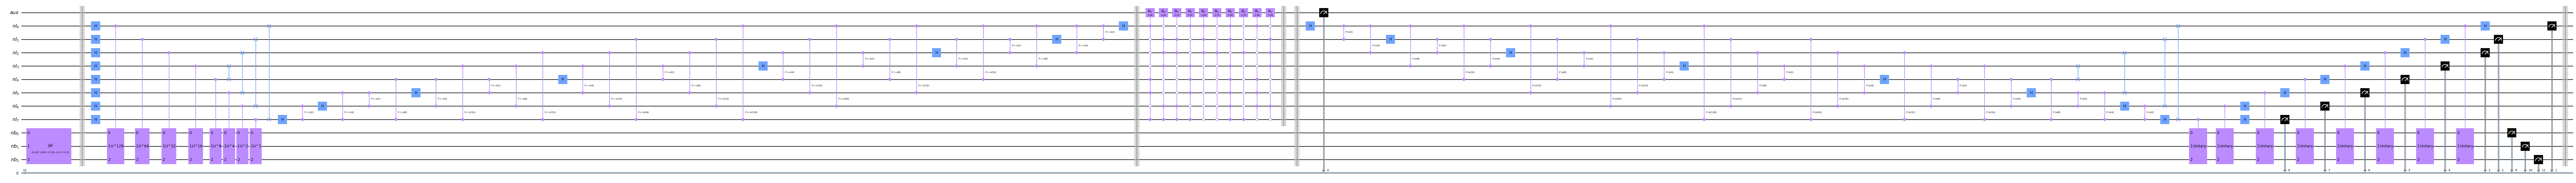

In [3]:
import numpy as np
from numpy import pi
import scipy
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate, RYGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

def hermitian_and_pad_matrix(A):
    zero = np.zeros_like(A)
    Ap = np.vstack((np.hstack((zero, A)), np.hstack((A.conj().T, zero))))
    A_p = np.pad(Ap, ((0, 2), (0, 2)))
    A_p[-1, -1], A_p[-2, -2] = 1, 1
    eig_val = np.linalg.eigvals(A_p)
    A_p /= max(np.real(eig_val))
    return A_p

def pad_b(b):
    return np.append(b, [0, 0, 0, 0, 0])

def construct_registers(n_eig, n):
    aux = QuantumRegister(1, 'aux')
    n_l = QuantumRegister(n_eig, 'nl')
    n_b = QuantumRegister(n, 'nb')
    c = ClassicalRegister(n + n_eig + 1, 'c')
    return aux, n_l, n_b, c

def construct_init_circ(aux, n_l, n_b, c, b_p):
    init_circ = QuantumCircuit(aux, n_l, n_b, c)
    b_p = b_p / np.linalg.norm(b_p)
    init_circ.initialize(b_p, n_b)
    init_circ.barrier()
    return init_circ

def convert_Ap_to_gate(A_p, T):
    U_mat = scipy.linalg.expm(1j * A_p * T)
    U = UnitaryGate(U_mat)
    U.name = "U"
    return U

def construct_qpe_circ(aux, n_l, n_b, c, U, n_eig):
    qpe_circ = QuantumCircuit(aux, n_l, n_b, c)
    qpe_circ.h(n_l)
    for i in range(n_eig):
        Upow = U.power(2 ** (n_eig - 1 - i))
        ctrl_Upow = Upow.control()
        qpe_circ.append(ctrl_Upow, [n_l[i], n_b[0], n_b[1], n_b[2]])
    # Inverse QFT (simplified)
    for qubit in range(n_eig // 2):
        qpe_circ.swap(n_l[qubit], n_l[n_eig - qubit - 1])
    for i in range(n_eig):
        for m in range(i):
            qpe_circ.cp(-pi / (2 ** (i - m)), n_l[n_eig - 1 - m], n_l[n_eig - 1 - i])
        qpe_circ.h(n_l[n_eig - 1 - i])
    qpe_circ.barrier() 
    return qpe_circ

def construct_qpe_measure_circ(init_circ, qpe_circ, n_l, c, n_eig):
    measure_circ = init_circ.compose(qpe_circ)
    measure_circ.measure(n_l, c[:n_eig])
    return measure_circ

def get_top_ev_bin(counts, n_eig):
    return [i[0][-n_eig:] for i in sorted(counts.items(), key=lambda i: i[1], reverse=True)[:10]]

def calculate_lmd_dec(bit_str):
    lmd = 0
    for ind, i in enumerate(bit_str[::-1]):
        lmd += int(i)/2**(ind+1)
    return lmd

def conditional_rotation(aux, n_l, c, top_ev_bin, n_eig, T):
    circ = QuantumCircuit(aux, n_l, c)
    for idx, ev_bin in enumerate(top_ev_bin):
        eigenvalue = calculate_lmd_dec(ev_bin)
        lambda_j = eigenvalue * (2 * pi / T)
        C = min(abs(lambda_j) - 0.0001, 0.5)
        theta = np.arcsin(C / lambda_j)
        ry = RYGate(2 * theta).control(n_eig, ctrl_state=ev_bin)
        wiring = [n_l[i] for i in range(n_eig)] + [aux[0]]
        circ.append(ry, wiring)
    circ.barrier()
    return circ

def inverse_qpe(qpe_circ):
    return qpe_circ.inverse()

def construct_full_circuit(init_circ, qpe_circ, cond_rot_circ, inv_qpe_circ, aux, n_l, n_b, c, n_eig, n):
    circ = init_circ.compose(qpe_circ).compose(cond_rot_circ).compose(inv_qpe_circ)
    circ.measure(aux, c[0])
    circ.measure(n_l, c[1:n_eig+1])
    circ.measure(n_b, c[n_eig+1:])
    circ.barrier()
    return circ

def extract_solution(final_counts, n, n_eig):
    filtered = {k: v for k, v in final_counts.items() if k[-(n + n_eig + 1)] == '1'}
    solution = np.zeros(2**n)
    total = sum(filtered.values())
    for k, v in filtered.items():
        nb_bits = k[:n][::-1]
        idx = int(nb_bits, 2)
        solution[idx] += v / total
    return solution

# Example usage
A = np.matrix([[1, 1, 0], [-1, 1, -1], [0, .13, 1.3]])
b = np.array([1, 3, 2])
T = 150
n_eig = 8
n = 3

A_p = hermitian_and_pad_matrix(A)
b_p = pad_b(b)
aux, n_l, n_b, c = construct_registers(n_eig, n)
init_circ = construct_init_circ(aux, n_l, n_b, c, b_p)
U = convert_Ap_to_gate(A_p, T)
qpe_circ = construct_qpe_circ(aux, n_l, n_b, c, U, n_eig)

# Plot QPE circuit
qpe_circ.draw('mpl', style='clifford')

measure_circ = construct_qpe_measure_circ(init_circ, qpe_circ, n_l, c, n_eig)

simulator = AerSimulator()
circ = transpile(measure_circ, simulator)
job = simulator.run(circ, shots=10000)
result = job.result()
counts = result.get_counts()

top_ev_bin = get_top_ev_bin(counts, n_eig)
cond_rot_circ = conditional_rotation(aux, n_l, c, top_ev_bin, n_eig, T)
inv_qpe_circ = inverse_qpe(qpe_circ)
full_circuit = construct_full_circuit(init_circ, qpe_circ, cond_rot_circ, inv_qpe_circ, aux, n_l, n_b, c, n_eig, n)

print("Full HHL Quantum Circuit:")
full_circuit.draw('mpl', style='clifford')

circ = transpile(full_circuit, simulator)
job = simulator.run(circ, shots=10000)
result = job.result()
final_counts = result.get_counts()

print("HHL Final Measurement Counts:")
print(final_counts)

solution = extract_solution(final_counts, n, n_eig)
print("Extracted solution vector (probabilities for each nb basis state):")
print(solution)

from qiskit.visualization import plot_histogram

# Plot histogram of final measurement counts
plot_histogram(final_counts)

# Calculate actual solution for comparison
def get_x_actual(A_p, b_p):
    x_actual = scipy.linalg.solve(A_p, b_p)
    x_norm = (x_actual / np.linalg.norm(x_actual))**2
    return [round(i, 3) for i in x_norm]

x_actual = get_x_actual(A_p, b_p)
print("Actual solution vector (normalized squared):")
print(x_actual)

# Compare extracted solution with actual solution
print("Extracted solution vector (from HHL):")
print(solution)

print("Difference (L2 norm):", np.linalg.norm(np.array(solution) - np.array(x_actual)))

# Plot QPE circuit
qpe_circ.draw('mpl', style='clifford')  # This alone does not display in Jupyter

# Correct way in Jupyter:
from qiskit.visualization import circuit_drawer
qpe_fig = qpe_circ.draw('mpl', style='clifford')
qpe_fig  # <-- This will display the QPE circuit

# For the full HHL circuit:
full_fig = full_circuit.draw('mpl', style='clifford', fold=-1)
full_fig  # <-- This will display the full HHL circuit

In [4]:
# Full HHL Implementation Example for Qiskit >= 1.0
# FINAL WORKING VERSION: Corrects the control logic for the rotation gate.

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT, RYGate
# You will need matplotlib to see the drawing
import matplotlib.pyplot as plt

# --- Helper function to create the controlled-U for QPE ---
def create_controlled_unitary(matrix: np.ndarray, num_io_qubits: int) -> QuantumCircuit:
    """Creates the controlled-U gate e^(iAt) needed for QPE."""
    from scipy.linalg import expm
    # For this problem, t=pi works well with 2 eigenvalue qubits
    t = np.pi
    unitary_op = expm(1j * matrix * t)
    unitary_circuit = QuantumCircuit(num_io_qubits, name="U")
    unitary_circuit.unitary(unitary_op, range(num_io_qubits))
    return unitary_circuit

# --- Main HHL Solver Function ---
def run_hhl(matrix: np.ndarray, vector: np.ndarray):
    """Constructs, runs, and analyzes the HHL algorithm."""
    
    num_io_qubits = int(np.log2(matrix.shape[0]))
    # Using 2 eigenvalue qubits
    num_eigenvalue_qubits = 2 
    
    # --- 1. Register Setup ---
    qr_io = QuantumRegister(num_io_qubits, name='io')
    qr_lambda = QuantumRegister(num_eigenvalue_qubits, name='lambda')
    qr_flag = QuantumRegister(1, name='flag')
    qc = QuantumCircuit(qr_io, qr_lambda, qr_flag)

    # --- 2. State Preparation for |b> ---
    norm_b = np.linalg.norm(vector)
    initial_state = vector / norm_b
    qc.initialize(initial_state, qr_io)
    qc.barrier()

    # --- 3. Quantum Phase Estimation (QPE) ---
    controlled_u_circuit = create_controlled_unitary(matrix, num_io_qubits)
    qc.h(qr_lambda)
    for i in range(num_eigenvalue_qubits):
        for _ in range(2**i):
            qc.append(controlled_u_circuit.control(1), [qr_lambda[i]] + qr_io[:])
    qc.barrier()
    qc.append(QFT(num_qubits=num_eigenvalue_qubits, inverse=True).to_instruction(), qr_lambda)
    qc.barrier()

    # --- 4. Controlled Rotation ---
    # For this problem's parameters, QPE maps eigenvalue lambda=2 to the state |00>
    # in the 2-qubit lambda register. We will control our rotation on this state.
    print("Applying controlled rotation for state |00>...")
    
    C = 0.5 # Scaling constant
    angle = 2 * np.arcsin(C / 2.0) # Angle for lambda=2
    
    # Create a doubly-controlled RY gate using the standard .control() method
    controlled_ry_gate = RYGate(angle).control(2)
    
    # To control on the |00> state of the lambda register (qr_lambda),
    # we surround the controls with X-gates. This is the "X-sandwich".
    qc.x(qr_lambda)
    qc.append(controlled_ry_gate, qr_lambda[:] + qr_flag[:])
    qc.x(qr_lambda)
    qc.barrier()

    # --- 5. Inverse QPE ---
    qc.append(QFT(num_qubits=num_eigenvalue_qubits, inverse=False).to_instruction(), qr_lambda)
    qc.barrier()
    for i in reversed(range(num_eigenvalue_qubits)):
        for _ in range(2**i):
            qc.append(controlled_u_circuit.control(1).inverse(), [qr_lambda[i]] + qr_io[:])
    qc.h(qr_lambda)
    qc.barrier()

    # --- 6. Draw the Circuit ---
    print("\nDrawing the full HHL circuit...")
    qc.draw('mpl', style='clifford', fold=-1)
    plt.show()

    # --- 7. Simulation and Comparison ---
    final_state = Statevector(qc)
    flag_qubit_index = qr_io.size + qr_lambda.size
    
    solution_amplitude = []
    full_space_dim = 2**qc.num_qubits
    for i in range(full_space_dim):
        if (i >> flag_qubit_index) & 1:
            io_state_index = i % (2**num_io_qubits)
            if len(solution_amplitude) <= io_state_index:
                solution_amplitude.extend([0] * (io_state_index - len(solution_amplitude) + 1))
            solution_amplitude[io_state_index] = final_state.data[i]
            
    classical_solution = np.linalg.solve(matrix, vector)
    
    hhl_vec = np.array(solution_amplitude)
    hhl_norm = np.linalg.norm(hhl_vec)
    if hhl_norm > 1e-9:
        hhl_normalized = hhl_vec / hhl_norm
    else:
        hhl_normalized = hhl_vec
        
    classical_normalized = classical_solution / np.linalg.norm(classical_solution)
    similarity = np.abs(np.vdot(classical_normalized, hhl_normalized))

    print("\n--- Results & Comparison ---")
    print(f"Classical Solution (Normalized): {np.round(classical_normalized, 4)}")
    print(f"HHL Solution (Normalized):       {np.round(hhl_normalized, 4)}")
    print(f"Cosine Similarity (Fidelity):    {similarity:.4f}")

# --- Main execution block ---
if __name__ == "__main__":
    A = np.array([[1.5, 0.5], [0.5, 1.5]])
    b = np.array([1, 1]) / np.sqrt(2)

    run_hhl(A, b)

Applying controlled rotation for state |00>...

Drawing the full HHL circuit...

--- Results & Comparison ---
Classical Solution (Normalized): [0.7071 0.7071]
HHL Solution (Normalized):       [0.+0.j 0.+0.j]
Cosine Similarity (Fidelity):    0.0000
